### Data exploration and loading common structures

In [14]:
import pandas as pd
import numpy as np
import csv as csv
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
# explore training data
train_df = pd.read_csv('../../data/train.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


---

After counting the number of missing data in each column, we can discard 'Cabin' since it has very little information. Further, 'Ticket' is mostly specific to passengers and can also be removed. 

In [30]:
print("Number of unique 'Ticket' values = {0}".format(len(train_df['Ticket'].unique())))
print("---------------------------------------")
print("Missing values in each column")
print(train_df.isnull().sum())

Number of unique 'Ticket' values = 681
---------------------------------------
Missing values in each column
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [31]:
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)

---

### Sex and Class correlation with survival

Below plot shows that most of the class 1 and 2 females survived, while majority of the male from class 3 did not survive.

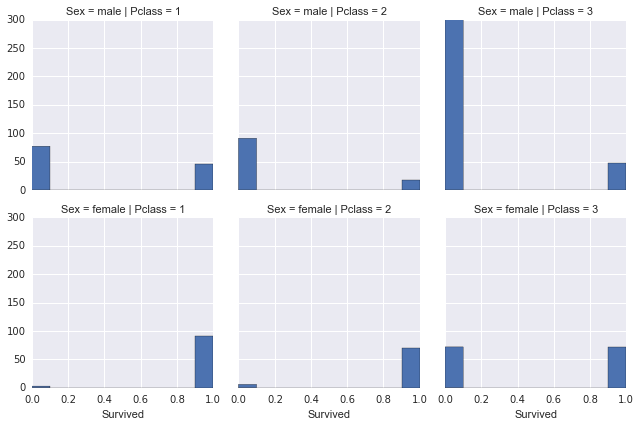

In [32]:
import seaborn as sns
g = sns.FacetGrid(train_df, row="Sex", col="Pclass", col_order=[1, 2, 3])
g.map(plt.hist, "Survived")